# GPU Version to run on MARCC

This notebook is assummed to be launched from the top level of the AutomaticLP github repo (where the notebook file is)

This also assummes that you've already cloed the tensorflow object detection project
https://github.com/tensorflow/models (since you need to do this to add the python path to  the bashrc file which has to be done before launching jupyter lab

Run with the LPproject kernel

## Setup / Installations

Add
<code>
export PYTHONPATH=$PYTHONPATH:`pwd`
export PYTHONPATH=$PYTHONPATH:`pwd`/slim

to your ~/.bashrc file where pwd is the full path to the models/research directory

### Tests that Tensorflow GPU is installed & this notebook can see the GPU 

These don't need to be run everytime but are here as a sanity / debugging check

In [ ]:
# test that tensorflow can access a GPU
import tensorflow as tf
tf.test.is_built_with_cuda()

In [ ]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

In [ ]:
print ('Default GPU Device: {}'.format(tf.test.gpu_device_name()))


In [ ]:
%%bash 
cd models/research
FILE=protobuf.zip
if [ ! -f "$FILE" ]; then
    wget -O protobuf.zip https://github.com/google/protobuf/releases/download/v3.0.0/protoc-3.0.0-linux-x86_64.zip
    unzip protobuf.zip
fi
./bin/protoc object_detection/protos/*.proto --python_out=.
pip install --user .

In [ ]:
!ml cuda/9.0
!export CUDA_VISIBLE_DEVICES=1
!echo ${CUDA_VISIBLE_DEVICES}

## Generating Datasets

The ScriptForBashFile generates both the training and test data and TFRecords from the image files

(For now hard coded to 100 images - TODO: switch back to user input, note then this won't be able to run with a bash script)

In [1]:
%run ScriptForBashFile

Enter the total number of samples (60% is training, 40% is testing):  10


TrainingImages_2020-04-12_09-38
Number of Instance of Each Character:
0 2
1 4
2 4
3 2
4 2
5 3
6 3
7 5
8 3
9 2
A 0
B 3
C 0
D 0
E 1
F 0
G 2
H 0
J 1
K 0
L 0
M 2
N 0
P 1
R 0
S 0
T 0
V 0
W 0
X 0
Y 1
Z 1
6  Training Images Generated
TestImages_2020-04-12_09-38
Number of Instance of Each Character:
0 4
1 6
2 8
3 5
4 3
5 4
6 3
7 6
8 6
9 5
A 0
B 4
C 0
D 0
E 1
F 0
G 3
H 0
J 1
K 0
L 0
M 2
N 0
P 2
R 0
S 1
T 0
V 0
W 1
X 1
Y 2
Z 2
4  Test Images Generated



## Train


In [ ]:
# If training output directory dosen't exist create it
!mkdir -p trainingOutput

In [2]:
# This makes the output of the next cell write to the file
# https://stackoverflow.com/questions/45200375/stdout-redirect-from-jupyter-notebook-is-landing-in-the-terminal
import sys
old_stdout = sys.stdout
sys.stdout = open('trainingLog.txt', 'w')

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.




Instructions for updating:
Use object_detection/model_main.py.


Instructions for updating:
Please switch to tf.train.create_global_step




Instructions for updating:
Use `tf.data.experimental.parallel_interleave(...)`.
Instructions for updating:
Use `tf.data.Dataset.interleave(map_func, cycle_length, block_length, num_parallel_calls=tf.data.experimental.AUTOTUNE)` instead. If sloppy execution is desired, use `tf.data.Options.experimental_determinstic`.
Instructions for updating:
Use `tf.data.Dataset.map()
Instructions for updating:
Use `for ... in dataset:` to iterate over a dataset. If using `tf.estimator`, return the `Dat

In [3]:
%cd models/research
%run object_detection/legacy/train.py --logtostderr --train_dir=../../trainingOutput/ --pipeline_config_path=../../FromScratch/models/model/ssd_mobilenet_v1_coco.config 
%cd ../..

W0412 09:39:16.520738 140345440180032 deprecation.py:323] From /home/christina/anaconda3/lib/python3.7/site-packages/absl/app.py:250: main (from __main__) is deprecated and will be removed in a future version.
Instructions for updating:
Use object_detection/model_main.py.
W0412 09:39:16.523317 140345440180032 module_wrapper.py:139] From /home/christina/Documents/Thesis/AutomaticLP/models/research/object_detection/legacy/train.py:91: The name tf.gfile.MakeDirs is deprecated. Please use tf.io.gfile.makedirs instead.

W0412 09:39:16.531312 140345440180032 module_wrapper.py:139] From /home/christina/Documents/Thesis/AutomaticLP/models/research/object_detection/legacy/train.py:96: The name tf.gfile.Copy is deprecated. Please use tf.io.gfile.copy instead.

W0412 09:39:16.538436 140345440180032 deprecation.py:323] From /home/christina/Documents/Thesis/AutomaticLP/models/research/object_detection/legacy/trainer.py:267: create_global_step (from tensorflow.contrib.framework.python.ops.variables)

KeyboardInterrupt: 

In [4]:
# Put the cell output back to normal
sys.stdout = old_stdout

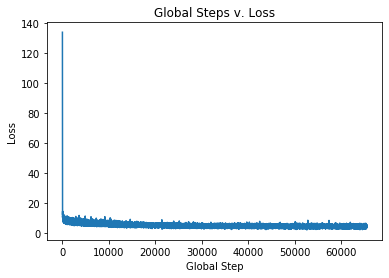

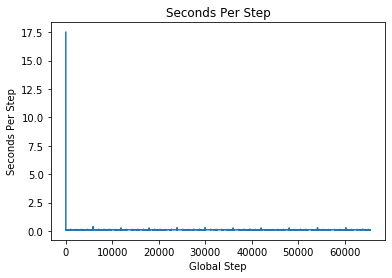

In [1]:
%matplotlib inline
%run viewTraining.py

## Evaluation



In [27]:
# We want to run Evaluation on the latest checkpoint 
# this code extracts the step number of the most recent checkpoint saved

from os import listdir
import re

%cd trainingOutput
checkpointList = listdir()
%cd ..

numbers = []
for filename in checkpointList:
    match = re.search("^model.ckpt-", filename)
    if not match is None:
        filename = filename.split(".")
        filename = filename[1].split("-")
        numbers.append(filename[1])

lastCheckpoint = max(numbers)

CHECKPOINT_PREFIX = "../../trainingOutput/model.ckpt-"+str(lastCheckpoint)

/home/christina/Documents/Thesis/AutomaticLP/trainingOutput
/home/christina/Documents/Thesis/AutomaticLP


In [29]:
%cd models/research
!python object_detection/export_inference_graph.py --input_type image_tensor --pipeline_config_path ../../FromScratch/models/model/ssd_mobilenet_v1_coco.config --trained_checkpoint_prefix $CHECKPOINT_PREFIX --output_directory ../../inference_graph
%cd ../..

/home/christina/Documents/Thesis/AutomaticLP/models/research
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



W0412 10:10:19.764824 139810515842880 module_wrapper.py:139] From object_detection/export_inference_graph.py:145: The name tf.gfile.GFile is deprecated. Please use tf.io.gfile.GFile instead.


W0412 10:10:19.769852 139810515842880 module_wrapper.py:139] From /home/christina/Documents/Thesis/AutomaticLP/models/research/object_detection/exporter.py:402: The name tf.gfile.MakeDirs is deprecated. Please use tf.io.gfile.makedirs instead.


W0412 10:10:19.770179 139810515842880 module_wrapper.py:139] From /home/christina/Documents/Thesis/AutomaticLP/models/research/object_

Enter Test Image Directory Name:  TestImages_2020-04-12_09-38
Enter Threshold (0-1) for object detection:  .5


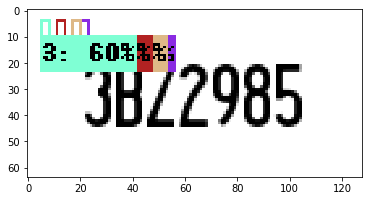

Show another image (y/n)?  y


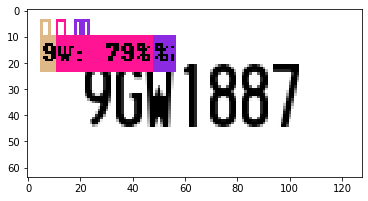

Show another image (y/n)?  y


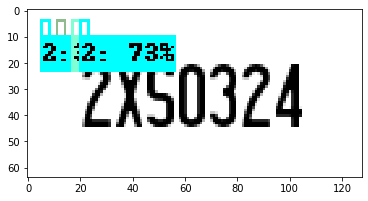

Show another image (y/n)?  n


In [32]:
%matplotlib inline
import matplotlib as plt
%run customEvaluation.py

In [33]:
%cd models/research
%run object_detection/inference/infer_detections.py --input_tfrecord_paths=../../FromScratch/TFRecordEval.tfrecord --inference_graph=../../inference_graph/frozen_inference_graph.pb --output_tfrecord_path=../../TFExamples.tfrecord
%cd ../..

/home/christina/Documents/Thesis/AutomaticLP/models/research




W0412 10:12:40.835751 140170411185984 module_wrapper.py:139] From /home/christina/Documents/Thesis/AutomaticLP/models/research/object_detection/inference/infer_detections.py:57: The name tf.logging.set_verbosity is deprecated. Please use tf.compat.v1.logging.set_verbosity instead.



W0412 10:12:40.837383 140170411185984 module_wrapper.py:139] From /home/christina/Documents/Thesis/AutomaticLP/models/research/object_detection/inference/infer_detections.py:57: The name tf.logging.INFO is deprecated. Please use tf.compat.v1.logging.INFO instead.



W0412 10:12:40.844712 140170411185984 module_wrapper.py:139] From /home/christina/Documents/Thesis/AutomaticLP/models/research/object_detection/inference/infer_detections.py:68: The name tf.logging.info is deprecated. Please use tf.compat.v1.logging.info instead.



INFO:tensorflow:Reading input from 1 files


I0412 10:12:40.847105 140170411185984 infer_detections.py:68] Reading input from 1 files


Instructions for updating:
Queue-based input pipelines have been replaced by `tf.data`. Use `tf.data.Dataset.from_tensor_slices(string_tensor).shuffle(tf.shape(input_tensor, out_type=tf.int64)[0]).repeat(num_epochs)`. If `shuffle=False`, omit the `.shuffle(...)`.


W0412 10:12:40.852351 140170411185984 deprecation.py:323] From /home/christina/Documents/Thesis/AutomaticLP/models/research/object_detection/inference/detection_inference.py:35: string_input_producer (from tensorflow.python.training.input) is deprecated and will be removed in a future version.
Instructions for updating:
Queue-based input pipelines have been replaced by `tf.data`. Use `tf.data.Dataset.from_tensor_slices(string_tensor).shuffle(tf.shape(input_tensor, out_type=tf.int64)[0]).repeat(num_epochs)`. If `shuffle=False`, omit the `.shuffle(...)`.


Instructions for updating:
Queue-based input pipelines have been replaced by `tf.data`. Use `tf.data.Dataset.from_tensor_slices(input_tensor).shuffle(tf.shape(input_tensor, out_type=tf.int64)[0]).repeat(num_epochs)`. If `shuffle=False`, omit the `.shuffle(...)`.


W0412 10:12:40.864382 140170411185984 deprecation.py:323] From /home/christina/.local/lib/python3.7/site-packages/tensorflow_core/python/training/input.py:277: input_producer (from tensorflow.python.training.input) is deprecated and will be removed in a future version.
Instructions for updating:
Queue-based input pipelines have been replaced by `tf.data`. Use `tf.data.Dataset.from_tensor_slices(input_tensor).shuffle(tf.shape(input_tensor, out_type=tf.int64)[0]).repeat(num_epochs)`. If `shuffle=False`, omit the `.shuffle(...)`.


Instructions for updating:
Queue-based input pipelines have been replaced by `tf.data`. Use `tf.data.Dataset.from_tensors(tensor).repeat(num_epochs)`.


W0412 10:12:40.867541 140170411185984 deprecation.py:323] From /home/christina/.local/lib/python3.7/site-packages/tensorflow_core/python/training/input.py:189: limit_epochs (from tensorflow.python.training.input) is deprecated and will be removed in a future version.
Instructions for updating:
Queue-based input pipelines have been replaced by `tf.data`. Use `tf.data.Dataset.from_tensors(tensor).repeat(num_epochs)`.


Instructions for updating:
Prefer Dataset.range instead.


W0412 10:12:40.876903 140170411185984 deprecation.py:323] From /home/christina/.local/lib/python3.7/site-packages/tensorflow_core/python/training/input.py:112: RefVariable.count_up_to (from tensorflow.python.ops.variables) is deprecated and will be removed in a future version.
Instructions for updating:
Prefer Dataset.range instead.


Instructions for updating:
Prefer Dataset.range instead.


W0412 10:12:40.878207 140170411185984 deprecation.py:323] From /home/christina/.local/lib/python3.7/site-packages/tensorflow_core/python/ops/variables.py:2522: count_up_to (from tensorflow.python.ops.state_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Prefer Dataset.range instead.


Instructions for updating:
To construct input pipelines, use the `tf.data` module.


W0412 10:12:40.883497 140170411185984 deprecation.py:323] From /home/christina/.local/lib/python3.7/site-packages/tensorflow_core/python/training/input.py:198: QueueRunner.__init__ (from tensorflow.python.training.queue_runner_impl) is deprecated and will be removed in a future version.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.


Instructions for updating:
To construct input pipelines, use the `tf.data` module.


W0412 10:12:40.886656 140170411185984 deprecation.py:323] From /home/christina/.local/lib/python3.7/site-packages/tensorflow_core/python/training/input.py:198: add_queue_runner (from tensorflow.python.training.queue_runner_impl) is deprecated and will be removed in a future version.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.


Instructions for updating:
Queue-based input pipelines have been replaced by `tf.data`. Use `tf.data.TFRecordDataset`.


W0412 10:12:40.898021 140170411185984 deprecation.py:323] From /home/christina/Documents/Thesis/AutomaticLP/models/research/object_detection/inference/detection_inference.py:37: TFRecordReader.__init__ (from tensorflow.python.ops.io_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Queue-based input pipelines have been replaced by `tf.data`. Use `tf.data.TFRecordDataset`.


W0412 10:12:40.904893 140170411185984 module_wrapper.py:139] From /home/christina/Documents/Thesis/AutomaticLP/models/research/object_detection/inference/detection_inference.py:39: The name tf.parse_single_example is deprecated. Please use tf.io.parse_single_example instead.



W0412 10:12:40.906293 140170411185984 module_wrapper.py:139] From /home/christina/Documents/Thesis/AutomaticLP/models/research/object_detection/inference/detection_inference.py:43: The name tf.FixedLenFeature is deprecated. Please use tf.io.FixedLenFeature instead.



INFO:tensorflow:Reading graph and building model...


I0412 10:12:40.993808 140170411185984 infer_detections.py:71] Reading graph and building model...


W0412 10:12:40.995092 140170411185984 module_wrapper.py:139] From /home/christina/Documents/Thesis/AutomaticLP/models/research/object_detection/inference/detection_inference.py:68: The name tf.gfile.Open is deprecated. Please use tf.io.gfile.GFile instead.



W0412 10:12:41.631952 140170411185984 module_wrapper.py:139] From /home/christina/Documents/Thesis/AutomaticLP/models/research/object_detection/inference/detection_inference.py:76: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.



INFO:tensorflow:Running inference and writing output to ../../TFExamples.tfrecord


I0412 10:12:41.653893 140170411185984 infer_detections.py:77] Running inference and writing output to ../../TFExamples.tfrecord


W0412 10:12:41.655469 140170411185984 module_wrapper.py:139] From /home/christina/Documents/Thesis/AutomaticLP/models/research/object_detection/inference/infer_detections.py:78: The name tf.local_variables_initializer is deprecated. Please use tf.compat.v1.local_variables_initializer instead.



Instructions for updating:
To construct input pipelines, use the `tf.data` module.


W0412 10:12:41.884680 140170411185984 deprecation.py:323] From /home/christina/Documents/Thesis/AutomaticLP/models/research/object_detection/inference/infer_detections.py:79: start_queue_runners (from tensorflow.python.training.queue_runner_impl) is deprecated and will be removed in a future version.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.


W0412 10:12:41.886916 140170411185984 module_wrapper.py:139] From /home/christina/Documents/Thesis/AutomaticLP/models/research/object_detection/inference/infer_detections.py:80: The name tf.python_io.TFRecordWriter is deprecated. Please use tf.io.TFRecordWriter instead.



W0412 10:12:41.889204 140170411185984 module_wrapper.py:139] From /home/christina/Documents/Thesis/AutomaticLP/models/research/object_detection/inference/infer_detections.py:84: The name tf.logging.log_every_n is deprecated. Please use tf.compat.v1.logging.log_every_n instead.



INFO:tensorflow:Processed 0 images...


I0412 10:12:41.891201 140170411185984 infer_detections.py:85] Processed 0 images...


W0412 10:12:41.896439 140170411185984 module_wrapper.py:139] From /home/christina/Documents/Thesis/AutomaticLP/models/research/object_detection/inference/detection_inference.py:117: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.



INFO:tensorflow:Processed 10 images...


I0412 10:12:43.414918 140170411185984 infer_detections.py:85] Processed 10 images...


INFO:tensorflow:Processed 20 images...


I0412 10:12:43.577867 140170411185984 infer_detections.py:85] Processed 20 images...


INFO:tensorflow:Processed 30 images...


I0412 10:12:43.735945 140170411185984 infer_detections.py:85] Processed 30 images...


INFO:tensorflow:Processed 40 images...


I0412 10:12:43.883389 140170411185984 infer_detections.py:85] Processed 40 images...


INFO:tensorflow:Processed 50 images...


I0412 10:12:44.028267 140170411185984 infer_detections.py:85] Processed 50 images...


INFO:tensorflow:Processed 60 images...


I0412 10:12:44.173435 140170411185984 infer_detections.py:85] Processed 60 images...


INFO:tensorflow:Processed 70 images...


I0412 10:12:44.318427 140170411185984 infer_detections.py:85] Processed 70 images...


INFO:tensorflow:Processed 80 images...


I0412 10:12:44.466376 140170411185984 infer_detections.py:85] Processed 80 images...


INFO:tensorflow:Processed 90 images...


I0412 10:12:44.614171 140170411185984 infer_detections.py:85] Processed 90 images...


INFO:tensorflow:Processed 100 images...


I0412 10:12:44.776874 140170411185984 infer_detections.py:85] Processed 100 images...


INFO:tensorflow:Processed 110 images...


I0412 10:12:44.969347 140170411185984 infer_detections.py:85] Processed 110 images...


INFO:tensorflow:Processed 120 images...


I0412 10:12:45.190865 140170411185984 infer_detections.py:85] Processed 120 images...


INFO:tensorflow:Processed 130 images...


I0412 10:12:45.385627 140170411185984 infer_detections.py:85] Processed 130 images...


INFO:tensorflow:Processed 140 images...


I0412 10:12:45.550786 140170411185984 infer_detections.py:85] Processed 140 images...


INFO:tensorflow:Processed 150 images...


I0412 10:12:45.700446 140170411185984 infer_detections.py:85] Processed 150 images...


INFO:tensorflow:Processed 160 images...


I0412 10:12:45.845252 140170411185984 infer_detections.py:85] Processed 160 images...


INFO:tensorflow:Processed 170 images...


I0412 10:12:46.010568 140170411185984 infer_detections.py:85] Processed 170 images...


INFO:tensorflow:Processed 180 images...


I0412 10:12:46.158884 140170411185984 infer_detections.py:85] Processed 180 images...


INFO:tensorflow:Processed 190 images...


I0412 10:12:46.308883 140170411185984 infer_detections.py:85] Processed 190 images...


INFO:tensorflow:Processed 200 images...


I0412 10:12:46.452860 140170411185984 infer_detections.py:85] Processed 200 images...


INFO:tensorflow:Processed 210 images...


I0412 10:12:46.609319 140170411185984 infer_detections.py:85] Processed 210 images...


INFO:tensorflow:Processed 220 images...


I0412 10:12:46.760728 140170411185984 infer_detections.py:85] Processed 220 images...


INFO:tensorflow:Processed 230 images...


I0412 10:12:46.907529 140170411185984 infer_detections.py:85] Processed 230 images...


INFO:tensorflow:Processed 240 images...


I0412 10:12:47.050233 140170411185984 infer_detections.py:85] Processed 240 images...


INFO:tensorflow:Processed 250 images...


I0412 10:12:47.190233 140170411185984 infer_detections.py:85] Processed 250 images...


INFO:tensorflow:Processed 260 images...


I0412 10:12:47.333374 140170411185984 infer_detections.py:85] Processed 260 images...


INFO:tensorflow:Processed 270 images...


I0412 10:12:47.492174 140170411185984 infer_detections.py:85] Processed 270 images...


INFO:tensorflow:Processed 280 images...


I0412 10:12:47.647537 140170411185984 infer_detections.py:85] Processed 280 images...


INFO:tensorflow:Processed 290 images...


I0412 10:12:47.790305 140170411185984 infer_detections.py:85] Processed 290 images...


INFO:tensorflow:Processed 300 images...


I0412 10:12:47.940460 140170411185984 infer_detections.py:85] Processed 300 images...


INFO:tensorflow:Processed 310 images...


I0412 10:12:48.084107 140170411185984 infer_detections.py:85] Processed 310 images...


INFO:tensorflow:Processed 320 images...


I0412 10:12:48.234987 140170411185984 infer_detections.py:85] Processed 320 images...


INFO:tensorflow:Processed 330 images...


I0412 10:12:48.384220 140170411185984 infer_detections.py:85] Processed 330 images...


INFO:tensorflow:Processed 340 images...


I0412 10:12:48.531171 140170411185984 infer_detections.py:85] Processed 340 images...


INFO:tensorflow:Processed 350 images...


I0412 10:12:48.680133 140170411185984 infer_detections.py:85] Processed 350 images...


INFO:tensorflow:Processed 360 images...


I0412 10:12:48.831896 140170411185984 infer_detections.py:85] Processed 360 images...


INFO:tensorflow:Processed 370 images...


I0412 10:12:48.986715 140170411185984 infer_detections.py:85] Processed 370 images...


INFO:tensorflow:Processed 380 images...


I0412 10:12:49.144022 140170411185984 infer_detections.py:85] Processed 380 images...


INFO:tensorflow:Processed 390 images...


I0412 10:12:49.291254 140170411185984 infer_detections.py:85] Processed 390 images...


INFO:tensorflow:Processed 400 images...


I0412 10:12:49.447196 140170411185984 infer_detections.py:85] Processed 400 images...


INFO:tensorflow:Processed 410 images...


I0412 10:12:49.609775 140170411185984 infer_detections.py:85] Processed 410 images...


INFO:tensorflow:Processed 420 images...


I0412 10:12:49.772073 140170411185984 infer_detections.py:85] Processed 420 images...


INFO:tensorflow:Processed 430 images...


I0412 10:12:49.921497 140170411185984 infer_detections.py:85] Processed 430 images...


INFO:tensorflow:Processed 440 images...


I0412 10:12:50.070009 140170411185984 infer_detections.py:85] Processed 440 images...


INFO:tensorflow:Processed 450 images...


I0412 10:12:50.218936 140170411185984 infer_detections.py:85] Processed 450 images...


INFO:tensorflow:Processed 460 images...


I0412 10:12:50.365046 140170411185984 infer_detections.py:85] Processed 460 images...


INFO:tensorflow:Processed 470 images...


I0412 10:12:50.517109 140170411185984 infer_detections.py:85] Processed 470 images...


INFO:tensorflow:Processed 480 images...


I0412 10:12:50.664065 140170411185984 infer_detections.py:85] Processed 480 images...


INFO:tensorflow:Processed 490 images...


I0412 10:12:50.829671 140170411185984 infer_detections.py:85] Processed 490 images...


INFO:tensorflow:Processed 500 images...


I0412 10:12:50.984399 140170411185984 infer_detections.py:85] Processed 500 images...


INFO:tensorflow:Processed 510 images...


I0412 10:12:51.139102 140170411185984 infer_detections.py:85] Processed 510 images...


INFO:tensorflow:Processed 520 images...


I0412 10:12:51.300402 140170411185984 infer_detections.py:85] Processed 520 images...


INFO:tensorflow:Processed 530 images...


I0412 10:12:51.445480 140170411185984 infer_detections.py:85] Processed 530 images...


INFO:tensorflow:Processed 540 images...


I0412 10:12:51.586282 140170411185984 infer_detections.py:85] Processed 540 images...


INFO:tensorflow:Processed 550 images...


I0412 10:12:51.729413 140170411185984 infer_detections.py:85] Processed 550 images...


INFO:tensorflow:Processed 560 images...


I0412 10:12:51.879426 140170411185984 infer_detections.py:85] Processed 560 images...


INFO:tensorflow:Processed 570 images...


I0412 10:12:52.027168 140170411185984 infer_detections.py:85] Processed 570 images...


INFO:tensorflow:Processed 580 images...


I0412 10:12:52.172460 140170411185984 infer_detections.py:85] Processed 580 images...


INFO:tensorflow:Processed 590 images...


I0412 10:12:52.318874 140170411185984 infer_detections.py:85] Processed 590 images...


INFO:tensorflow:Processed 600 images...


I0412 10:12:52.466280 140170411185984 infer_detections.py:85] Processed 600 images...


INFO:tensorflow:Processed 610 images...


I0412 10:12:52.616256 140170411185984 infer_detections.py:85] Processed 610 images...


INFO:tensorflow:Processed 620 images...


I0412 10:12:52.771561 140170411185984 infer_detections.py:85] Processed 620 images...


INFO:tensorflow:Processed 630 images...


I0412 10:12:52.915265 140170411185984 infer_detections.py:85] Processed 630 images...


INFO:tensorflow:Processed 640 images...


I0412 10:12:53.059682 140170411185984 infer_detections.py:85] Processed 640 images...


INFO:tensorflow:Processed 650 images...


I0412 10:12:53.205002 140170411185984 infer_detections.py:85] Processed 650 images...


INFO:tensorflow:Processed 660 images...


I0412 10:12:53.348604 140170411185984 infer_detections.py:85] Processed 660 images...


INFO:tensorflow:Processed 670 images...


I0412 10:12:53.495478 140170411185984 infer_detections.py:85] Processed 670 images...


INFO:tensorflow:Processed 680 images...


I0412 10:12:53.643646 140170411185984 infer_detections.py:85] Processed 680 images...


INFO:tensorflow:Processed 690 images...


I0412 10:12:53.787504 140170411185984 infer_detections.py:85] Processed 690 images...


INFO:tensorflow:Processed 700 images...


I0412 10:12:53.954043 140170411185984 infer_detections.py:85] Processed 700 images...


INFO:tensorflow:Processed 710 images...


I0412 10:12:54.112202 140170411185984 infer_detections.py:85] Processed 710 images...


INFO:tensorflow:Processed 720 images...


I0412 10:12:54.264961 140170411185984 infer_detections.py:85] Processed 720 images...


INFO:tensorflow:Processed 730 images...


I0412 10:12:54.414909 140170411185984 infer_detections.py:85] Processed 730 images...


INFO:tensorflow:Processed 740 images...


I0412 10:12:54.572339 140170411185984 infer_detections.py:85] Processed 740 images...


INFO:tensorflow:Processed 750 images...


I0412 10:12:54.718799 140170411185984 infer_detections.py:85] Processed 750 images...


INFO:tensorflow:Processed 760 images...


I0412 10:12:54.869521 140170411185984 infer_detections.py:85] Processed 760 images...


INFO:tensorflow:Processed 770 images...


I0412 10:12:55.062144 140170411185984 infer_detections.py:85] Processed 770 images...


INFO:tensorflow:Processed 780 images...


I0412 10:12:55.225057 140170411185984 infer_detections.py:85] Processed 780 images...


INFO:tensorflow:Processed 790 images...


I0412 10:12:55.375856 140170411185984 infer_detections.py:85] Processed 790 images...


INFO:tensorflow:Processed 800 images...


I0412 10:12:55.520614 140170411185984 infer_detections.py:85] Processed 800 images...


INFO:tensorflow:Processed 810 images...


I0412 10:12:55.666053 140170411185984 infer_detections.py:85] Processed 810 images...


INFO:tensorflow:Processed 820 images...


I0412 10:12:55.809489 140170411185984 infer_detections.py:85] Processed 820 images...


INFO:tensorflow:Processed 830 images...


I0412 10:12:55.973998 140170411185984 infer_detections.py:85] Processed 830 images...


INFO:tensorflow:Processed 840 images...


I0412 10:12:56.119377 140170411185984 infer_detections.py:85] Processed 840 images...


INFO:tensorflow:Processed 850 images...


I0412 10:12:56.287668 140170411185984 infer_detections.py:85] Processed 850 images...


INFO:tensorflow:Processed 860 images...


I0412 10:12:56.446376 140170411185984 infer_detections.py:85] Processed 860 images...


INFO:tensorflow:Processed 870 images...


I0412 10:12:56.602864 140170411185984 infer_detections.py:85] Processed 870 images...


INFO:tensorflow:Processed 880 images...


I0412 10:12:56.758676 140170411185984 infer_detections.py:85] Processed 880 images...


INFO:tensorflow:Processed 890 images...


I0412 10:12:56.912335 140170411185984 infer_detections.py:85] Processed 890 images...


INFO:tensorflow:Processed 900 images...


I0412 10:12:57.073373 140170411185984 infer_detections.py:85] Processed 900 images...


INFO:tensorflow:Processed 910 images...


I0412 10:12:57.225478 140170411185984 infer_detections.py:85] Processed 910 images...


INFO:tensorflow:Processed 920 images...


I0412 10:12:57.383265 140170411185984 infer_detections.py:85] Processed 920 images...


INFO:tensorflow:Processed 930 images...


I0412 10:12:57.539009 140170411185984 infer_detections.py:85] Processed 930 images...


INFO:tensorflow:Processed 940 images...


I0412 10:12:57.698987 140170411185984 infer_detections.py:85] Processed 940 images...


INFO:tensorflow:Processed 950 images...


I0412 10:12:57.843396 140170411185984 infer_detections.py:85] Processed 950 images...


INFO:tensorflow:Processed 960 images...


I0412 10:12:57.992594 140170411185984 infer_detections.py:85] Processed 960 images...


INFO:tensorflow:Processed 970 images...


I0412 10:12:58.143646 140170411185984 infer_detections.py:85] Processed 970 images...


INFO:tensorflow:Processed 980 images...


I0412 10:12:58.297204 140170411185984 infer_detections.py:85] Processed 980 images...


INFO:tensorflow:Processed 990 images...


I0412 10:12:58.450851 140170411185984 infer_detections.py:85] Processed 990 images...


INFO:tensorflow:Processed 1000 images...


I0412 10:12:58.598098 140170411185984 infer_detections.py:85] Processed 1000 images...


INFO:tensorflow:Processed 1010 images...


I0412 10:12:58.745087 140170411185984 infer_detections.py:85] Processed 1010 images...


INFO:tensorflow:Processed 1020 images...


I0412 10:12:58.890746 140170411185984 infer_detections.py:85] Processed 1020 images...


INFO:tensorflow:Processed 1030 images...


I0412 10:12:59.035562 140170411185984 infer_detections.py:85] Processed 1030 images...


INFO:tensorflow:Processed 1040 images...


I0412 10:12:59.182723 140170411185984 infer_detections.py:85] Processed 1040 images...


INFO:tensorflow:Processed 1050 images...


I0412 10:12:59.327862 140170411185984 infer_detections.py:85] Processed 1050 images...


INFO:tensorflow:Processed 1060 images...


I0412 10:12:59.472771 140170411185984 infer_detections.py:85] Processed 1060 images...


INFO:tensorflow:Processed 1070 images...


I0412 10:12:59.621233 140170411185984 infer_detections.py:85] Processed 1070 images...


INFO:tensorflow:Processed 1080 images...


I0412 10:12:59.766092 140170411185984 infer_detections.py:85] Processed 1080 images...


INFO:tensorflow:Processed 1090 images...


I0412 10:12:59.913763 140170411185984 infer_detections.py:85] Processed 1090 images...


INFO:tensorflow:Processed 1100 images...


I0412 10:13:00.061795 140170411185984 infer_detections.py:85] Processed 1100 images...


INFO:tensorflow:Processed 1110 images...


I0412 10:13:00.204561 140170411185984 infer_detections.py:85] Processed 1110 images...


INFO:tensorflow:Processed 1120 images...


I0412 10:13:00.347679 140170411185984 infer_detections.py:85] Processed 1120 images...


INFO:tensorflow:Processed 1130 images...


I0412 10:13:00.497028 140170411185984 infer_detections.py:85] Processed 1130 images...


INFO:tensorflow:Processed 1140 images...


I0412 10:13:00.642504 140170411185984 infer_detections.py:85] Processed 1140 images...


INFO:tensorflow:Processed 1150 images...


I0412 10:13:00.786561 140170411185984 infer_detections.py:85] Processed 1150 images...


INFO:tensorflow:Processed 1160 images...


I0412 10:13:00.928861 140170411185984 infer_detections.py:85] Processed 1160 images...


INFO:tensorflow:Processed 1170 images...


I0412 10:13:01.077476 140170411185984 infer_detections.py:85] Processed 1170 images...


INFO:tensorflow:Processed 1180 images...


I0412 10:13:01.232880 140170411185984 infer_detections.py:85] Processed 1180 images...


INFO:tensorflow:Processed 1190 images...


I0412 10:13:01.374813 140170411185984 infer_detections.py:85] Processed 1190 images...


INFO:tensorflow:Processed 1200 images...


I0412 10:13:01.522408 140170411185984 infer_detections.py:85] Processed 1200 images...


INFO:tensorflow:Processed 1210 images...


I0412 10:13:01.666203 140170411185984 infer_detections.py:85] Processed 1210 images...


INFO:tensorflow:Processed 1220 images...


I0412 10:13:01.813312 140170411185984 infer_detections.py:85] Processed 1220 images...


INFO:tensorflow:Processed 1230 images...


I0412 10:13:01.959698 140170411185984 infer_detections.py:85] Processed 1230 images...


INFO:tensorflow:Processed 1240 images...


I0412 10:13:02.119833 140170411185984 infer_detections.py:85] Processed 1240 images...


INFO:tensorflow:Processed 1250 images...


I0412 10:13:02.273853 140170411185984 infer_detections.py:85] Processed 1250 images...


INFO:tensorflow:Processed 1260 images...


I0412 10:13:02.431931 140170411185984 infer_detections.py:85] Processed 1260 images...


INFO:tensorflow:Processed 1270 images...


I0412 10:13:02.579072 140170411185984 infer_detections.py:85] Processed 1270 images...


INFO:tensorflow:Processed 1280 images...


I0412 10:13:02.751575 140170411185984 infer_detections.py:85] Processed 1280 images...


INFO:tensorflow:Processed 1290 images...


I0412 10:13:02.918761 140170411185984 infer_detections.py:85] Processed 1290 images...


INFO:tensorflow:Processed 1300 images...


I0412 10:13:03.071294 140170411185984 infer_detections.py:85] Processed 1300 images...


INFO:tensorflow:Processed 1310 images...


I0412 10:13:03.217928 140170411185984 infer_detections.py:85] Processed 1310 images...


INFO:tensorflow:Processed 1320 images...


I0412 10:13:03.362206 140170411185984 infer_detections.py:85] Processed 1320 images...


INFO:tensorflow:Processed 1330 images...


I0412 10:13:03.510241 140170411185984 infer_detections.py:85] Processed 1330 images...


INFO:tensorflow:Processed 1340 images...


I0412 10:13:03.671361 140170411185984 infer_detections.py:85] Processed 1340 images...


INFO:tensorflow:Processed 1350 images...


I0412 10:13:03.824337 140170411185984 infer_detections.py:85] Processed 1350 images...


INFO:tensorflow:Processed 1360 images...


I0412 10:13:03.986495 140170411185984 infer_detections.py:85] Processed 1360 images...


INFO:tensorflow:Processed 1370 images...


I0412 10:13:04.139793 140170411185984 infer_detections.py:85] Processed 1370 images...


INFO:tensorflow:Processed 1380 images...


I0412 10:13:04.304900 140170411185984 infer_detections.py:85] Processed 1380 images...


INFO:tensorflow:Processed 1390 images...


I0412 10:13:04.460753 140170411185984 infer_detections.py:85] Processed 1390 images...


INFO:tensorflow:Processed 1400 images...


I0412 10:13:04.610474 140170411185984 infer_detections.py:85] Processed 1400 images...


INFO:tensorflow:Processed 1410 images...


I0412 10:13:04.774515 140170411185984 infer_detections.py:85] Processed 1410 images...


INFO:tensorflow:Processed 1420 images...


I0412 10:13:04.933703 140170411185984 infer_detections.py:85] Processed 1420 images...


INFO:tensorflow:Processed 1430 images...


I0412 10:13:05.084372 140170411185984 infer_detections.py:85] Processed 1430 images...


INFO:tensorflow:Processed 1440 images...


I0412 10:13:05.251767 140170411185984 infer_detections.py:85] Processed 1440 images...


INFO:tensorflow:Processed 1450 images...


I0412 10:13:05.403872 140170411185984 infer_detections.py:85] Processed 1450 images...


INFO:tensorflow:Processed 1460 images...


I0412 10:13:05.579147 140170411185984 infer_detections.py:85] Processed 1460 images...


INFO:tensorflow:Processed 1470 images...


I0412 10:13:05.747843 140170411185984 infer_detections.py:85] Processed 1470 images...


INFO:tensorflow:Processed 1480 images...


I0412 10:13:05.896036 140170411185984 infer_detections.py:85] Processed 1480 images...


INFO:tensorflow:Processed 1490 images...


I0412 10:13:06.056552 140170411185984 infer_detections.py:85] Processed 1490 images...


INFO:tensorflow:Processed 1500 images...


I0412 10:13:06.207193 140170411185984 infer_detections.py:85] Processed 1500 images...


INFO:tensorflow:Processed 1510 images...


I0412 10:13:06.384183 140170411185984 infer_detections.py:85] Processed 1510 images...


INFO:tensorflow:Processed 1520 images...


I0412 10:13:06.544238 140170411185984 infer_detections.py:85] Processed 1520 images...


INFO:tensorflow:Processed 1530 images...


I0412 10:13:06.696560 140170411185984 infer_detections.py:85] Processed 1530 images...


INFO:tensorflow:Processed 1540 images...


I0412 10:13:06.838703 140170411185984 infer_detections.py:85] Processed 1540 images...


INFO:tensorflow:Processed 1550 images...


I0412 10:13:06.994085 140170411185984 infer_detections.py:85] Processed 1550 images...


INFO:tensorflow:Processed 1560 images...


I0412 10:13:07.153740 140170411185984 infer_detections.py:85] Processed 1560 images...


INFO:tensorflow:Processed 1570 images...


I0412 10:13:07.307940 140170411185984 infer_detections.py:85] Processed 1570 images...


INFO:tensorflow:Processed 1580 images...


I0412 10:13:07.477743 140170411185984 infer_detections.py:85] Processed 1580 images...


INFO:tensorflow:Processed 1590 images...


I0412 10:13:07.627094 140170411185984 infer_detections.py:85] Processed 1590 images...


INFO:tensorflow:Processed 1600 images...


I0412 10:13:07.792649 140170411185984 infer_detections.py:85] Processed 1600 images...


INFO:tensorflow:Processed 1610 images...


I0412 10:13:07.950153 140170411185984 infer_detections.py:85] Processed 1610 images...


INFO:tensorflow:Processed 1620 images...


I0412 10:13:08.106486 140170411185984 infer_detections.py:85] Processed 1620 images...


INFO:tensorflow:Processed 1630 images...


I0412 10:13:08.271892 140170411185984 infer_detections.py:85] Processed 1630 images...


INFO:tensorflow:Processed 1640 images...


I0412 10:13:08.430002 140170411185984 infer_detections.py:85] Processed 1640 images...


INFO:tensorflow:Processed 1650 images...


I0412 10:13:08.591479 140170411185984 infer_detections.py:85] Processed 1650 images...


INFO:tensorflow:Processed 1660 images...


I0412 10:13:08.751689 140170411185984 infer_detections.py:85] Processed 1660 images...


INFO:tensorflow:Processed 1670 images...


I0412 10:13:08.925288 140170411185984 infer_detections.py:85] Processed 1670 images...


INFO:tensorflow:Processed 1680 images...


I0412 10:13:09.083231 140170411185984 infer_detections.py:85] Processed 1680 images...


INFO:tensorflow:Processed 1690 images...


I0412 10:13:09.264111 140170411185984 infer_detections.py:85] Processed 1690 images...


INFO:tensorflow:Processed 1700 images...


I0412 10:13:09.417495 140170411185984 infer_detections.py:85] Processed 1700 images...


INFO:tensorflow:Processed 1710 images...


I0412 10:13:09.572639 140170411185984 infer_detections.py:85] Processed 1710 images...


INFO:tensorflow:Processed 1720 images...


I0412 10:13:09.726819 140170411185984 infer_detections.py:85] Processed 1720 images...


INFO:tensorflow:Processed 1730 images...


I0412 10:13:09.873447 140170411185984 infer_detections.py:85] Processed 1730 images...


INFO:tensorflow:Processed 1740 images...


I0412 10:13:10.019442 140170411185984 infer_detections.py:85] Processed 1740 images...


INFO:tensorflow:Processed 1750 images...


I0412 10:13:10.165305 140170411185984 infer_detections.py:85] Processed 1750 images...


INFO:tensorflow:Processed 1760 images...


I0412 10:13:10.311527 140170411185984 infer_detections.py:85] Processed 1760 images...


INFO:tensorflow:Processed 1770 images...


I0412 10:13:10.457482 140170411185984 infer_detections.py:85] Processed 1770 images...


INFO:tensorflow:Processed 1780 images...


I0412 10:13:10.600458 140170411185984 infer_detections.py:85] Processed 1780 images...


INFO:tensorflow:Processed 1790 images...


I0412 10:13:10.752206 140170411185984 infer_detections.py:85] Processed 1790 images...


INFO:tensorflow:Processed 1800 images...


I0412 10:13:10.897126 140170411185984 infer_detections.py:85] Processed 1800 images...


INFO:tensorflow:Processed 1810 images...


I0412 10:13:11.036410 140170411185984 infer_detections.py:85] Processed 1810 images...


INFO:tensorflow:Processed 1820 images...


I0412 10:13:11.198425 140170411185984 infer_detections.py:85] Processed 1820 images...


INFO:tensorflow:Processed 1830 images...


I0412 10:13:11.349136 140170411185984 infer_detections.py:85] Processed 1830 images...


INFO:tensorflow:Processed 1840 images...


I0412 10:13:11.504166 140170411185984 infer_detections.py:85] Processed 1840 images...


INFO:tensorflow:Processed 1850 images...


I0412 10:13:11.666412 140170411185984 infer_detections.py:85] Processed 1850 images...


INFO:tensorflow:Processed 1860 images...


I0412 10:13:11.817292 140170411185984 infer_detections.py:85] Processed 1860 images...


INFO:tensorflow:Processed 1870 images...


I0412 10:13:11.968049 140170411185984 infer_detections.py:85] Processed 1870 images...


INFO:tensorflow:Processed 1880 images...


I0412 10:13:12.115187 140170411185984 infer_detections.py:85] Processed 1880 images...


INFO:tensorflow:Processed 1890 images...


I0412 10:13:12.259504 140170411185984 infer_detections.py:85] Processed 1890 images...


INFO:tensorflow:Processed 1900 images...


I0412 10:13:12.400946 140170411185984 infer_detections.py:85] Processed 1900 images...


INFO:tensorflow:Processed 1910 images...


I0412 10:13:12.546594 140170411185984 infer_detections.py:85] Processed 1910 images...


INFO:tensorflow:Processed 1920 images...


I0412 10:13:12.714901 140170411185984 infer_detections.py:85] Processed 1920 images...


INFO:tensorflow:Processed 1930 images...


I0412 10:13:12.866836 140170411185984 infer_detections.py:85] Processed 1930 images...


INFO:tensorflow:Processed 1940 images...


I0412 10:13:13.016261 140170411185984 infer_detections.py:85] Processed 1940 images...


INFO:tensorflow:Processed 1950 images...


I0412 10:13:13.171141 140170411185984 infer_detections.py:85] Processed 1950 images...


INFO:tensorflow:Processed 1960 images...


I0412 10:13:13.323978 140170411185984 infer_detections.py:85] Processed 1960 images...


INFO:tensorflow:Processed 1970 images...


I0412 10:13:13.475168 140170411185984 infer_detections.py:85] Processed 1970 images...


INFO:tensorflow:Processed 1980 images...


I0412 10:13:13.626681 140170411185984 infer_detections.py:85] Processed 1980 images...


INFO:tensorflow:Processed 1990 images...


I0412 10:13:13.799518 140170411185984 infer_detections.py:85] Processed 1990 images...


INFO:tensorflow:Processed 2000 images...


I0412 10:13:13.953797 140170411185984 infer_detections.py:85] Processed 2000 images...


INFO:tensorflow:Processed 2010 images...


I0412 10:13:14.106352 140170411185984 infer_detections.py:85] Processed 2010 images...


INFO:tensorflow:Processed 2020 images...


I0412 10:13:14.266029 140170411185984 infer_detections.py:85] Processed 2020 images...


INFO:tensorflow:Processed 2030 images...


I0412 10:13:14.422738 140170411185984 infer_detections.py:85] Processed 2030 images...


INFO:tensorflow:Processed 2040 images...


I0412 10:13:14.579568 140170411185984 infer_detections.py:85] Processed 2040 images...


INFO:tensorflow:Processed 2050 images...


I0412 10:13:14.737379 140170411185984 infer_detections.py:85] Processed 2050 images...


INFO:tensorflow:Processed 2060 images...


I0412 10:13:14.895743 140170411185984 infer_detections.py:85] Processed 2060 images...


INFO:tensorflow:Processed 2070 images...


I0412 10:13:15.052932 140170411185984 infer_detections.py:85] Processed 2070 images...


INFO:tensorflow:Processed 2080 images...


I0412 10:13:15.208952 140170411185984 infer_detections.py:85] Processed 2080 images...


INFO:tensorflow:Processed 2090 images...


I0412 10:13:15.356162 140170411185984 infer_detections.py:85] Processed 2090 images...


INFO:tensorflow:Processed 2100 images...


I0412 10:13:15.507959 140170411185984 infer_detections.py:85] Processed 2100 images...


INFO:tensorflow:Processed 2110 images...


I0412 10:13:15.652203 140170411185984 infer_detections.py:85] Processed 2110 images...


INFO:tensorflow:Processed 2120 images...


I0412 10:13:15.800142 140170411185984 infer_detections.py:85] Processed 2120 images...


INFO:tensorflow:Processed 2130 images...


I0412 10:13:15.952430 140170411185984 infer_detections.py:85] Processed 2130 images...


INFO:tensorflow:Processed 2140 images...


I0412 10:13:16.122089 140170411185984 infer_detections.py:85] Processed 2140 images...


INFO:tensorflow:Processed 2150 images...


I0412 10:13:16.271208 140170411185984 infer_detections.py:85] Processed 2150 images...


INFO:tensorflow:Processed 2160 images...


I0412 10:13:16.416723 140170411185984 infer_detections.py:85] Processed 2160 images...


INFO:tensorflow:Processed 2170 images...


I0412 10:13:16.567646 140170411185984 infer_detections.py:85] Processed 2170 images...


INFO:tensorflow:Processed 2180 images...


I0412 10:13:16.725975 140170411185984 infer_detections.py:85] Processed 2180 images...


INFO:tensorflow:Processed 2190 images...


I0412 10:13:16.887458 140170411185984 infer_detections.py:85] Processed 2190 images...


INFO:tensorflow:Processed 2200 images...


I0412 10:13:17.040448 140170411185984 infer_detections.py:85] Processed 2200 images...


INFO:tensorflow:Processed 2210 images...


I0412 10:13:17.188091 140170411185984 infer_detections.py:85] Processed 2210 images...


INFO:tensorflow:Processed 2220 images...


I0412 10:13:17.332212 140170411185984 infer_detections.py:85] Processed 2220 images...


INFO:tensorflow:Processed 2230 images...


I0412 10:13:17.481374 140170411185984 infer_detections.py:85] Processed 2230 images...


INFO:tensorflow:Processed 2240 images...


I0412 10:13:17.627593 140170411185984 infer_detections.py:85] Processed 2240 images...


INFO:tensorflow:Processed 2250 images...


I0412 10:13:17.771162 140170411185984 infer_detections.py:85] Processed 2250 images...


INFO:tensorflow:Processed 2260 images...


I0412 10:13:17.913597 140170411185984 infer_detections.py:85] Processed 2260 images...


INFO:tensorflow:Processed 2270 images...


I0412 10:13:18.066844 140170411185984 infer_detections.py:85] Processed 2270 images...


INFO:tensorflow:Processed 2280 images...


I0412 10:13:18.210033 140170411185984 infer_detections.py:85] Processed 2280 images...


INFO:tensorflow:Processed 2290 images...


I0412 10:13:18.361412 140170411185984 infer_detections.py:85] Processed 2290 images...


INFO:tensorflow:Processed 2300 images...


I0412 10:13:18.528706 140170411185984 infer_detections.py:85] Processed 2300 images...


INFO:tensorflow:Processed 2310 images...


I0412 10:13:18.688934 140170411185984 infer_detections.py:85] Processed 2310 images...


INFO:tensorflow:Processed 2320 images...


I0412 10:13:18.847207 140170411185984 infer_detections.py:85] Processed 2320 images...


INFO:tensorflow:Processed 2330 images...


I0412 10:13:19.003567 140170411185984 infer_detections.py:85] Processed 2330 images...


INFO:tensorflow:Processed 2340 images...


I0412 10:13:19.157445 140170411185984 infer_detections.py:85] Processed 2340 images...


INFO:tensorflow:Processed 2350 images...


I0412 10:13:19.317825 140170411185984 infer_detections.py:85] Processed 2350 images...


INFO:tensorflow:Processed 2360 images...


I0412 10:13:19.474436 140170411185984 infer_detections.py:85] Processed 2360 images...


INFO:tensorflow:Processed 2370 images...


I0412 10:13:19.622705 140170411185984 infer_detections.py:85] Processed 2370 images...


INFO:tensorflow:Processed 2380 images...


I0412 10:13:19.780697 140170411185984 infer_detections.py:85] Processed 2380 images...


INFO:tensorflow:Processed 2390 images...


I0412 10:13:19.929107 140170411185984 infer_detections.py:85] Processed 2390 images...


INFO:tensorflow:Processed 2400 images...


I0412 10:13:20.070227 140170411185984 infer_detections.py:85] Processed 2400 images...


INFO:tensorflow:Processed 2410 images...


I0412 10:13:20.213755 140170411185984 infer_detections.py:85] Processed 2410 images...


INFO:tensorflow:Processed 2420 images...


I0412 10:13:20.365741 140170411185984 infer_detections.py:85] Processed 2420 images...


INFO:tensorflow:Processed 2430 images...


I0412 10:13:20.524314 140170411185984 infer_detections.py:85] Processed 2430 images...


INFO:tensorflow:Processed 2440 images...


I0412 10:13:20.679981 140170411185984 infer_detections.py:85] Processed 2440 images...


INFO:tensorflow:Processed 2450 images...


I0412 10:13:20.843656 140170411185984 infer_detections.py:85] Processed 2450 images...


INFO:tensorflow:Processed 2460 images...


I0412 10:13:20.995779 140170411185984 infer_detections.py:85] Processed 2460 images...


INFO:tensorflow:Processed 2470 images...


I0412 10:13:21.145917 140170411185984 infer_detections.py:85] Processed 2470 images...


INFO:tensorflow:Processed 2480 images...


I0412 10:13:21.316065 140170411185984 infer_detections.py:85] Processed 2480 images...


INFO:tensorflow:Processed 2490 images...


I0412 10:13:21.462659 140170411185984 infer_detections.py:85] Processed 2490 images...


INFO:tensorflow:Processed 2500 images...


I0412 10:13:21.603886 140170411185984 infer_detections.py:85] Processed 2500 images...


INFO:tensorflow:Processed 2510 images...


I0412 10:13:21.750876 140170411185984 infer_detections.py:85] Processed 2510 images...


INFO:tensorflow:Processed 2520 images...


I0412 10:13:21.892841 140170411185984 infer_detections.py:85] Processed 2520 images...


INFO:tensorflow:Processed 2530 images...


I0412 10:13:22.042541 140170411185984 infer_detections.py:85] Processed 2530 images...


INFO:tensorflow:Processed 2540 images...


I0412 10:13:22.186662 140170411185984 infer_detections.py:85] Processed 2540 images...


INFO:tensorflow:Processed 2550 images...


I0412 10:13:22.333086 140170411185984 infer_detections.py:85] Processed 2550 images...


INFO:tensorflow:Processed 2560 images...


I0412 10:13:22.477862 140170411185984 infer_detections.py:85] Processed 2560 images...


INFO:tensorflow:Processed 2570 images...


I0412 10:13:22.622216 140170411185984 infer_detections.py:85] Processed 2570 images...


INFO:tensorflow:Processed 2580 images...


I0412 10:13:22.772941 140170411185984 infer_detections.py:85] Processed 2580 images...


INFO:tensorflow:Processed 2590 images...


I0412 10:13:22.921398 140170411185984 infer_detections.py:85] Processed 2590 images...


INFO:tensorflow:Processed 2600 images...


I0412 10:13:23.069853 140170411185984 infer_detections.py:85] Processed 2600 images...


INFO:tensorflow:Processed 2610 images...


I0412 10:13:23.215682 140170411185984 infer_detections.py:85] Processed 2610 images...


INFO:tensorflow:Processed 2620 images...


I0412 10:13:23.357888 140170411185984 infer_detections.py:85] Processed 2620 images...


INFO:tensorflow:Processed 2630 images...


I0412 10:13:23.502619 140170411185984 infer_detections.py:85] Processed 2630 images...


INFO:tensorflow:Processed 2640 images...


I0412 10:13:23.644206 140170411185984 infer_detections.py:85] Processed 2640 images...


INFO:tensorflow:Processed 2650 images...


I0412 10:13:23.789180 140170411185984 infer_detections.py:85] Processed 2650 images...


INFO:tensorflow:Processed 2660 images...


I0412 10:13:23.942032 140170411185984 infer_detections.py:85] Processed 2660 images...


INFO:tensorflow:Processed 2670 images...


I0412 10:13:24.117285 140170411185984 infer_detections.py:85] Processed 2670 images...


INFO:tensorflow:Processed 2680 images...


I0412 10:13:24.313208 140170411185984 infer_detections.py:85] Processed 2680 images...


INFO:tensorflow:Processed 2690 images...


I0412 10:13:24.459869 140170411185984 infer_detections.py:85] Processed 2690 images...


INFO:tensorflow:Processed 2700 images...


I0412 10:13:24.648846 140170411185984 infer_detections.py:85] Processed 2700 images...


INFO:tensorflow:Processed 2710 images...


I0412 10:13:24.851430 140170411185984 infer_detections.py:85] Processed 2710 images...


INFO:tensorflow:Processed 2720 images...


I0412 10:13:25.061130 140170411185984 infer_detections.py:85] Processed 2720 images...


INFO:tensorflow:Processed 2730 images...


I0412 10:13:25.255330 140170411185984 infer_detections.py:85] Processed 2730 images...


INFO:tensorflow:Processed 2740 images...


I0412 10:13:25.435648 140170411185984 infer_detections.py:85] Processed 2740 images...


INFO:tensorflow:Processed 2750 images...


I0412 10:13:25.577569 140170411185984 infer_detections.py:85] Processed 2750 images...


INFO:tensorflow:Processed 2760 images...


I0412 10:13:25.760743 140170411185984 infer_detections.py:85] Processed 2760 images...


INFO:tensorflow:Processed 2770 images...


I0412 10:13:25.942934 140170411185984 infer_detections.py:85] Processed 2770 images...


INFO:tensorflow:Processed 2780 images...


I0412 10:13:26.158625 140170411185984 infer_detections.py:85] Processed 2780 images...


INFO:tensorflow:Processed 2790 images...


I0412 10:13:26.352773 140170411185984 infer_detections.py:85] Processed 2790 images...


INFO:tensorflow:Processed 2800 images...


I0412 10:13:26.540165 140170411185984 infer_detections.py:85] Processed 2800 images...


INFO:tensorflow:Processed 2810 images...


I0412 10:13:26.743318 140170411185984 infer_detections.py:85] Processed 2810 images...


INFO:tensorflow:Processed 2820 images...


I0412 10:13:26.891844 140170411185984 infer_detections.py:85] Processed 2820 images...


INFO:tensorflow:Processed 2830 images...


I0412 10:13:27.048446 140170411185984 infer_detections.py:85] Processed 2830 images...


INFO:tensorflow:Processed 2840 images...


I0412 10:13:27.194334 140170411185984 infer_detections.py:85] Processed 2840 images...


INFO:tensorflow:Processed 2850 images...


I0412 10:13:27.340028 140170411185984 infer_detections.py:85] Processed 2850 images...


INFO:tensorflow:Processed 2860 images...


I0412 10:13:27.494899 140170411185984 infer_detections.py:85] Processed 2860 images...


INFO:tensorflow:Processed 2870 images...


I0412 10:13:27.652929 140170411185984 infer_detections.py:85] Processed 2870 images...


INFO:tensorflow:Processed 2880 images...


I0412 10:13:27.803317 140170411185984 infer_detections.py:85] Processed 2880 images...


INFO:tensorflow:Processed 2890 images...


I0412 10:13:27.978730 140170411185984 infer_detections.py:85] Processed 2890 images...


INFO:tensorflow:Processed 2900 images...


I0412 10:13:28.131596 140170411185984 infer_detections.py:85] Processed 2900 images...


INFO:tensorflow:Processed 2910 images...


I0412 10:13:28.293834 140170411185984 infer_detections.py:85] Processed 2910 images...


INFO:tensorflow:Processed 2920 images...


I0412 10:13:28.448452 140170411185984 infer_detections.py:85] Processed 2920 images...


INFO:tensorflow:Processed 2930 images...


I0412 10:13:28.607381 140170411185984 infer_detections.py:85] Processed 2930 images...


INFO:tensorflow:Processed 2940 images...


I0412 10:13:28.764373 140170411185984 infer_detections.py:85] Processed 2940 images...


INFO:tensorflow:Processed 2950 images...


I0412 10:13:28.932561 140170411185984 infer_detections.py:85] Processed 2950 images...


INFO:tensorflow:Processed 2960 images...


I0412 10:13:29.086925 140170411185984 infer_detections.py:85] Processed 2960 images...


INFO:tensorflow:Processed 2970 images...


I0412 10:13:29.239805 140170411185984 infer_detections.py:85] Processed 2970 images...


INFO:tensorflow:Processed 2980 images...


I0412 10:13:29.398910 140170411185984 infer_detections.py:85] Processed 2980 images...


INFO:tensorflow:Processed 2990 images...


I0412 10:13:29.546418 140170411185984 infer_detections.py:85] Processed 2990 images...


INFO:tensorflow:Processed 3000 images...


I0412 10:13:29.692633 140170411185984 infer_detections.py:85] Processed 3000 images...


INFO:tensorflow:Processed 3010 images...


I0412 10:13:29.840039 140170411185984 infer_detections.py:85] Processed 3010 images...


INFO:tensorflow:Processed 3020 images...


I0412 10:13:29.997118 140170411185984 infer_detections.py:85] Processed 3020 images...


INFO:tensorflow:Processed 3030 images...


I0412 10:13:30.153650 140170411185984 infer_detections.py:85] Processed 3030 images...


INFO:tensorflow:Processed 3040 images...


I0412 10:13:30.306066 140170411185984 infer_detections.py:85] Processed 3040 images...


INFO:tensorflow:Processed 3050 images...


I0412 10:13:30.461643 140170411185984 infer_detections.py:85] Processed 3050 images...


INFO:tensorflow:Processed 3060 images...


I0412 10:13:30.630342 140170411185984 infer_detections.py:85] Processed 3060 images...


INFO:tensorflow:Processed 3070 images...


I0412 10:13:30.798461 140170411185984 infer_detections.py:85] Processed 3070 images...


INFO:tensorflow:Processed 3080 images...


I0412 10:13:30.967729 140170411185984 infer_detections.py:85] Processed 3080 images...


INFO:tensorflow:Processed 3090 images...


I0412 10:13:31.130015 140170411185984 infer_detections.py:85] Processed 3090 images...


INFO:tensorflow:Processed 3100 images...


I0412 10:13:31.315667 140170411185984 infer_detections.py:85] Processed 3100 images...


INFO:tensorflow:Processed 3110 images...


I0412 10:13:31.489586 140170411185984 infer_detections.py:85] Processed 3110 images...


INFO:tensorflow:Processed 3120 images...


I0412 10:13:31.652852 140170411185984 infer_detections.py:85] Processed 3120 images...


INFO:tensorflow:Processed 3130 images...


I0412 10:13:31.816071 140170411185984 infer_detections.py:85] Processed 3130 images...


INFO:tensorflow:Processed 3140 images...


I0412 10:13:31.999659 140170411185984 infer_detections.py:85] Processed 3140 images...


INFO:tensorflow:Processed 3150 images...


I0412 10:13:32.165424 140170411185984 infer_detections.py:85] Processed 3150 images...


INFO:tensorflow:Processed 3160 images...


I0412 10:13:32.332623 140170411185984 infer_detections.py:85] Processed 3160 images...


INFO:tensorflow:Processed 3170 images...


I0412 10:13:32.499062 140170411185984 infer_detections.py:85] Processed 3170 images...


INFO:tensorflow:Processed 3180 images...


I0412 10:13:32.664479 140170411185984 infer_detections.py:85] Processed 3180 images...


INFO:tensorflow:Processed 3190 images...


I0412 10:13:32.844302 140170411185984 infer_detections.py:85] Processed 3190 images...


INFO:tensorflow:Processed 3200 images...


I0412 10:13:33.009092 140170411185984 infer_detections.py:85] Processed 3200 images...


INFO:tensorflow:Processed 3210 images...


I0412 10:13:33.169757 140170411185984 infer_detections.py:85] Processed 3210 images...


INFO:tensorflow:Processed 3220 images...


I0412 10:13:33.331406 140170411185984 infer_detections.py:85] Processed 3220 images...


INFO:tensorflow:Processed 3230 images...


I0412 10:13:33.488325 140170411185984 infer_detections.py:85] Processed 3230 images...


INFO:tensorflow:Processed 3240 images...


I0412 10:13:33.639024 140170411185984 infer_detections.py:85] Processed 3240 images...


INFO:tensorflow:Processed 3250 images...


I0412 10:13:33.791046 140170411185984 infer_detections.py:85] Processed 3250 images...


INFO:tensorflow:Processed 3260 images...


I0412 10:13:33.943965 140170411185984 infer_detections.py:85] Processed 3260 images...


INFO:tensorflow:Processed 3270 images...


I0412 10:13:34.100210 140170411185984 infer_detections.py:85] Processed 3270 images...


INFO:tensorflow:Processed 3280 images...


I0412 10:13:34.252761 140170411185984 infer_detections.py:85] Processed 3280 images...


INFO:tensorflow:Processed 3290 images...


I0412 10:13:34.404680 140170411185984 infer_detections.py:85] Processed 3290 images...


INFO:tensorflow:Processed 3300 images...


I0412 10:13:34.558804 140170411185984 infer_detections.py:85] Processed 3300 images...


INFO:tensorflow:Processed 3310 images...


I0412 10:13:34.708202 140170411185984 infer_detections.py:85] Processed 3310 images...


INFO:tensorflow:Processed 3320 images...


I0412 10:13:34.870247 140170411185984 infer_detections.py:85] Processed 3320 images...


INFO:tensorflow:Processed 3330 images...


I0412 10:13:35.033910 140170411185984 infer_detections.py:85] Processed 3330 images...


INFO:tensorflow:Processed 3340 images...


I0412 10:13:35.187813 140170411185984 infer_detections.py:85] Processed 3340 images...


INFO:tensorflow:Processed 3350 images...


I0412 10:13:35.344094 140170411185984 infer_detections.py:85] Processed 3350 images...


INFO:tensorflow:Processed 3360 images...


I0412 10:13:35.502820 140170411185984 infer_detections.py:85] Processed 3360 images...


INFO:tensorflow:Processed 3370 images...


I0412 10:13:35.658293 140170411185984 infer_detections.py:85] Processed 3370 images...


INFO:tensorflow:Processed 3380 images...


I0412 10:13:35.819468 140170411185984 infer_detections.py:85] Processed 3380 images...


INFO:tensorflow:Processed 3390 images...


I0412 10:13:35.985707 140170411185984 infer_detections.py:85] Processed 3390 images...


INFO:tensorflow:Processed 3400 images...


I0412 10:13:36.159768 140170411185984 infer_detections.py:85] Processed 3400 images...


INFO:tensorflow:Processed 3410 images...


I0412 10:13:36.334821 140170411185984 infer_detections.py:85] Processed 3410 images...


INFO:tensorflow:Processed 3420 images...


I0412 10:13:36.495107 140170411185984 infer_detections.py:85] Processed 3420 images...


INFO:tensorflow:Processed 3430 images...


I0412 10:13:36.648319 140170411185984 infer_detections.py:85] Processed 3430 images...


INFO:tensorflow:Processed 3440 images...


I0412 10:13:36.801755 140170411185984 infer_detections.py:85] Processed 3440 images...


INFO:tensorflow:Processed 3450 images...


I0412 10:13:36.955856 140170411185984 infer_detections.py:85] Processed 3450 images...


INFO:tensorflow:Processed 3460 images...


I0412 10:13:37.108041 140170411185984 infer_detections.py:85] Processed 3460 images...


INFO:tensorflow:Processed 3470 images...


I0412 10:13:37.267390 140170411185984 infer_detections.py:85] Processed 3470 images...


INFO:tensorflow:Processed 3480 images...


I0412 10:13:37.421899 140170411185984 infer_detections.py:85] Processed 3480 images...


INFO:tensorflow:Processed 3490 images...


I0412 10:13:37.606449 140170411185984 infer_detections.py:85] Processed 3490 images...


INFO:tensorflow:Processed 3500 images...


I0412 10:13:37.789143 140170411185984 infer_detections.py:85] Processed 3500 images...


INFO:tensorflow:Processed 3510 images...


I0412 10:13:37.963140 140170411185984 infer_detections.py:85] Processed 3510 images...


INFO:tensorflow:Processed 3520 images...


I0412 10:13:38.133341 140170411185984 infer_detections.py:85] Processed 3520 images...


INFO:tensorflow:Processed 3530 images...


I0412 10:13:38.302069 140170411185984 infer_detections.py:85] Processed 3530 images...


INFO:tensorflow:Processed 3540 images...


I0412 10:13:38.469809 140170411185984 infer_detections.py:85] Processed 3540 images...


INFO:tensorflow:Processed 3550 images...


I0412 10:13:38.639583 140170411185984 infer_detections.py:85] Processed 3550 images...


INFO:tensorflow:Processed 3560 images...


I0412 10:13:38.825615 140170411185984 infer_detections.py:85] Processed 3560 images...


INFO:tensorflow:Processed 3570 images...


I0412 10:13:38.990721 140170411185984 infer_detections.py:85] Processed 3570 images...


INFO:tensorflow:Processed 3580 images...


I0412 10:13:39.153624 140170411185984 infer_detections.py:85] Processed 3580 images...


INFO:tensorflow:Processed 3590 images...


I0412 10:13:39.322896 140170411185984 infer_detections.py:85] Processed 3590 images...


INFO:tensorflow:Processed 3600 images...


I0412 10:13:39.498548 140170411185984 infer_detections.py:85] Processed 3600 images...


INFO:tensorflow:Processed 3610 images...


I0412 10:13:39.663224 140170411185984 infer_detections.py:85] Processed 3610 images...


INFO:tensorflow:Processed 3620 images...


I0412 10:13:39.835062 140170411185984 infer_detections.py:85] Processed 3620 images...


INFO:tensorflow:Processed 3630 images...


I0412 10:13:39.999429 140170411185984 infer_detections.py:85] Processed 3630 images...


INFO:tensorflow:Processed 3640 images...


I0412 10:13:40.167704 140170411185984 infer_detections.py:85] Processed 3640 images...


INFO:tensorflow:Processed 3650 images...


I0412 10:13:40.333678 140170411185984 infer_detections.py:85] Processed 3650 images...


INFO:tensorflow:Processed 3660 images...


I0412 10:13:40.500385 140170411185984 infer_detections.py:85] Processed 3660 images...


INFO:tensorflow:Processed 3670 images...


I0412 10:13:40.672289 140170411185984 infer_detections.py:85] Processed 3670 images...


INFO:tensorflow:Processed 3680 images...


I0412 10:13:40.840292 140170411185984 infer_detections.py:85] Processed 3680 images...


INFO:tensorflow:Processed 3690 images...


I0412 10:13:41.013946 140170411185984 infer_detections.py:85] Processed 3690 images...


INFO:tensorflow:Processed 3700 images...


I0412 10:13:41.181425 140170411185984 infer_detections.py:85] Processed 3700 images...


INFO:tensorflow:Processed 3710 images...


I0412 10:13:41.370587 140170411185984 infer_detections.py:85] Processed 3710 images...


INFO:tensorflow:Processed 3720 images...


I0412 10:13:41.534673 140170411185984 infer_detections.py:85] Processed 3720 images...


INFO:tensorflow:Processed 3730 images...


I0412 10:13:41.701278 140170411185984 infer_detections.py:85] Processed 3730 images...


INFO:tensorflow:Processed 3740 images...


I0412 10:13:41.856309 140170411185984 infer_detections.py:85] Processed 3740 images...


INFO:tensorflow:Processed 3750 images...


I0412 10:13:42.028603 140170411185984 infer_detections.py:85] Processed 3750 images...


INFO:tensorflow:Processed 3760 images...


I0412 10:13:42.187141 140170411185984 infer_detections.py:85] Processed 3760 images...


INFO:tensorflow:Processed 3770 images...


I0412 10:13:42.364262 140170411185984 infer_detections.py:85] Processed 3770 images...


INFO:tensorflow:Processed 3780 images...


I0412 10:13:42.531720 140170411185984 infer_detections.py:85] Processed 3780 images...


INFO:tensorflow:Processed 3790 images...


I0412 10:13:42.695833 140170411185984 infer_detections.py:85] Processed 3790 images...


INFO:tensorflow:Processed 3800 images...


I0412 10:13:42.870249 140170411185984 infer_detections.py:85] Processed 3800 images...


INFO:tensorflow:Processed 3810 images...


I0412 10:13:43.038360 140170411185984 infer_detections.py:85] Processed 3810 images...


INFO:tensorflow:Processed 3820 images...


I0412 10:13:43.212840 140170411185984 infer_detections.py:85] Processed 3820 images...


INFO:tensorflow:Processed 3830 images...


I0412 10:13:43.389825 140170411185984 infer_detections.py:85] Processed 3830 images...


INFO:tensorflow:Processed 3840 images...


I0412 10:13:43.562695 140170411185984 infer_detections.py:85] Processed 3840 images...


INFO:tensorflow:Processed 3850 images...


I0412 10:13:43.735002 140170411185984 infer_detections.py:85] Processed 3850 images...


INFO:tensorflow:Processed 3860 images...


I0412 10:13:43.904351 140170411185984 infer_detections.py:85] Processed 3860 images...


INFO:tensorflow:Processed 3870 images...


I0412 10:13:44.067368 140170411185984 infer_detections.py:85] Processed 3870 images...


INFO:tensorflow:Processed 3880 images...


I0412 10:13:44.240077 140170411185984 infer_detections.py:85] Processed 3880 images...


INFO:tensorflow:Processed 3890 images...


I0412 10:13:44.406233 140170411185984 infer_detections.py:85] Processed 3890 images...


INFO:tensorflow:Processed 3900 images...


I0412 10:13:44.580395 140170411185984 infer_detections.py:85] Processed 3900 images...


INFO:tensorflow:Processed 3910 images...


I0412 10:13:44.749444 140170411185984 infer_detections.py:85] Processed 3910 images...


INFO:tensorflow:Processed 3920 images...


I0412 10:13:44.916207 140170411185984 infer_detections.py:85] Processed 3920 images...


INFO:tensorflow:Processed 3930 images...


I0412 10:13:45.081912 140170411185984 infer_detections.py:85] Processed 3930 images...


INFO:tensorflow:Processed 3940 images...


I0412 10:13:45.251186 140170411185984 infer_detections.py:85] Processed 3940 images...


INFO:tensorflow:Processed 3950 images...


I0412 10:13:45.414662 140170411185984 infer_detections.py:85] Processed 3950 images...


INFO:tensorflow:Processed 3960 images...


I0412 10:13:45.585057 140170411185984 infer_detections.py:85] Processed 3960 images...


INFO:tensorflow:Processed 3970 images...


I0412 10:13:45.753934 140170411185984 infer_detections.py:85] Processed 3970 images...


INFO:tensorflow:Processed 3980 images...


I0412 10:13:45.919439 140170411185984 infer_detections.py:85] Processed 3980 images...


INFO:tensorflow:Processed 3990 images...


I0412 10:13:46.108157 140170411185984 infer_detections.py:85] Processed 3990 images...


INFO:tensorflow:Processed 4000 images...


I0412 10:13:46.278093 140170411185984 infer_detections.py:85] Processed 4000 images...


INFO:tensorflow:Finished processing records


I0412 10:13:46.300397 140170411185984 infer_detections.py:92] Finished processing records


/home/christina/Documents/Thesis/AutomaticLP


/home/christina/Documents/Thesis/AutomaticLP/tf_object_detection_cm
Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


W0412 10:13:49.284458 140170411185984 deprecation.py:323] From /home/christina/Documents/Thesis/AutomaticLP/tf_object_detection_cm/confusion_matrix.py:45: tf_record_iterator (from tensorflow.python.lib.io.tf_record) is deprecated and will be removed in a future version.
Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


Processed 100 images
Processed 200 images
Processed 300 images
Processed 400 images
Processed 400 images

Confusion Matrix:
[[ 30.   0.   0. ...   0.   0. 160.]
 [  0.  43.   0. ...   0.   0. 153.]
 [  0.   3.   0. ...   0.   0. 203.]
 ...
 [  0.   0.   0. ...   0.   0.  33.]
 [  0.   0.   0. ...   0.   0. 188.]
 [  4.   0.   0. ...   0.   0.   0.]] 

   category  precision_@0.5IOU  recall_@0.5IOU
0         0                NaN        0.000000
1         1           0.535714        0.157895
2         2           0.934783        0.219388
3         3                NaN        0.000000
4         4           1.000000        0.025641
5         5           1.000000        0.043956
6         6           1.000000        0.101449
7         7           1.000000        0.058824
8         8           0.015873        0.005181
9         9                NaN        0.000000
10        A                NaN        0.000000
11        B                NaN        0.000000
12        C                NaN     

/home/christina/Documents/Thesis/AutomaticLP/tf_object_detection_cm/confusion_matrix.py:125: RuntimeWarning: invalid value encountered in double_scalars
  precision = float(confusion_matrix[id, id] / total_predicted)


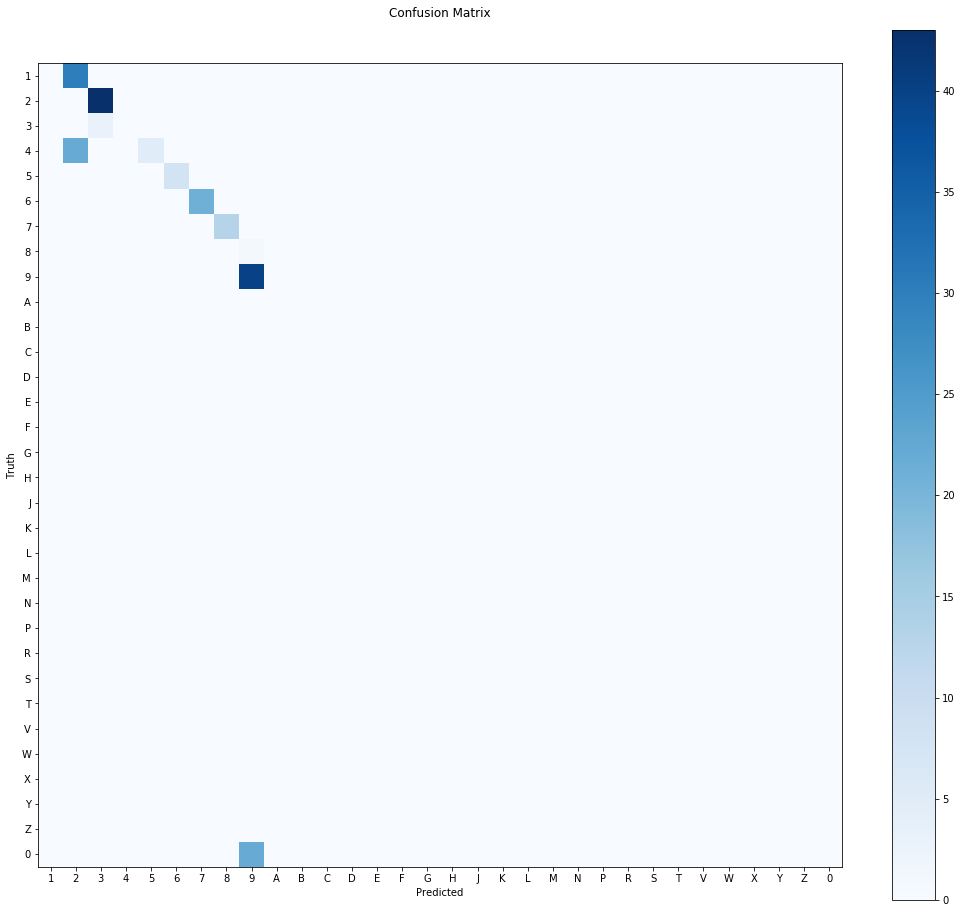

/home/christina/Documents/Thesis/AutomaticLP


In [34]:
%cd tf_object_detection_cm
%run confusion_matrix.py --detections_record=../Test.tfrecord --label_map=../FromScratch/data/label_map.pbtxt --output_path=confusion_matrix.csv
%cd ..